In [69]:
#Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [70]:
#library to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [71]:
#load train and test datsets and assign flag variable Set to determine if Train or Test dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train['Set'] = "Train"
test['Set'] = "Test"

In [72]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Set
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,Train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,Train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,Train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,Train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,Train


In [73]:
#Dependant variable y is SalePrice
y_train = train.SalePrice

Skewness: 1.8828757597682129


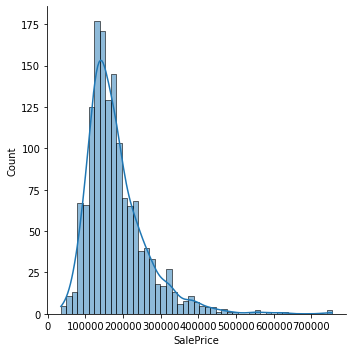

In [74]:
#Lets analyze our y-variable: SalePrice using a histogram
sns.displot(y_train, kde=True)
print("Skewness: {}".format(y_train.skew()))
#We can see that the histo is left skewed which makes sense, as most of the houses will be in the lower range and 
#there can be houses at the top end

In [76]:
#Correlation between SalePrice and the various predictors in descending order
#We can see that OverallQual, GrLivArea and GarageCars have the most correlation with SalePrice in decending order
train.corr()['SalePrice'].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

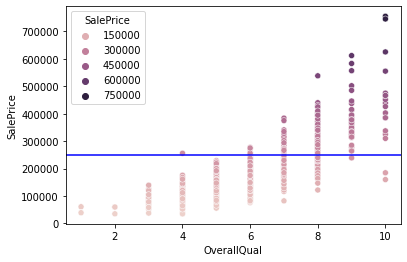

In [77]:
#Lets analyze these 3 variables as these will matter a lot in our predictions
#First let analyze OverallQual
sns.scatterplot(data=train, x='OverallQual', y='SalePrice', hue = 'SalePrice')
plt.axhline(y=250000,color='b')
#We can see 2 outliers for OverallQual = 10 where their SalePrice < 250000

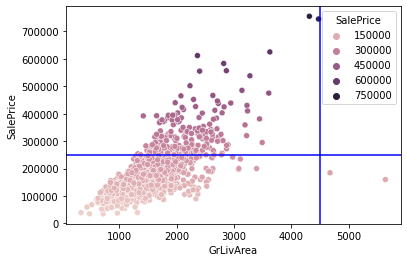

In [78]:
#Second let analyze GrLivArea
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice', hue = 'SalePrice')
plt.axhline(y=250000,color='b')
plt.axvline(x = 4500, color = 'b')
#We can see 2 outliers for GrLivArea > 4500 where their SalePrice < 250000

In [79]:
#Now lets find out if these 2 outliers between the 2 scatterplots are the same
train[(train['OverallQual']==10) &(train['SalePrice']<250000)][['SalePrice', 'GrLivArea', 'OverallQual']]

,SalePrice,GrLivArea,OverallQual
523,184750,4676,10
1298,160000,5642,10


In [80]:
train[(train['GrLivArea']>4500) & (train['SalePrice']<250000)][['SalePrice', 'GrLivArea', 'OverallQual']]

,SalePrice,GrLivArea,OverallQual
523,184750,4676,10
1298,160000,5642,10


In [81]:
#It looks like the 2 outliers are the same
#Let us drop these 2 rows from the train dataset as these will affect our regression
index_drop=train[(train['GrLivArea']>4500) & (train['SalePrice']<250000)].index
train=train.drop(index_drop, axis=0)

In [82]:
#Combine test and train datasets to prepare the data
test['SalePrice'] = -1
DATA = train.append(test)
DATA.reset_index(inplace=True)

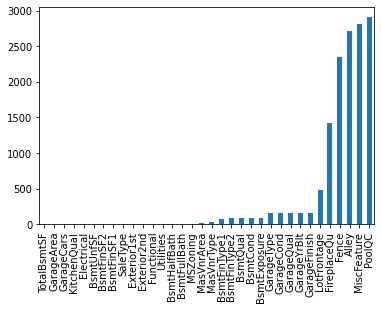

In [83]:
#Missing Data visualization
DATA[DATA.columns[DATA.isna().sum() > 0]].isna().sum().sort_values().plot.bar();

In [84]:
#We can see that there are a lot of missing values for the features PoolQC, MiscFeature, Alley, Fence
DATA.isna().sum().sort_values(ascending=False).head(20)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
dtype: int64

In [85]:
#Lets drop the top 4 features
DATA = DATA.drop(['PoolQC','MiscFeature','Alley','Fence'], axis=1)

In [86]:
#Managing missing values for the other features
#Now lets impute missing values in numeric features with median
# We can apply this function to all the numeric features together
data_numeric = DATA.select_dtypes(include = [np.number])
numeric_cols = data_numeric.columns.values

for col in numeric_cols:
    missing = DATA[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:
        print('imputing missing values for : {}'.format(col))
        med = DATA[col].median()
        DATA[col] = DATA[col].fillna(med)

imputing missing values for : LotFrontage
imputing missing values for : MasVnrArea
imputing missing values for : BsmtFinSF1
imputing missing values for : BsmtFinSF2
imputing missing values for : BsmtUnfSF
imputing missing values for : TotalBsmtSF
imputing missing values for : BsmtFullBath
imputing missing values for : BsmtHalfBath
imputing missing values for : GarageYrBlt
imputing missing values for : GarageCars
imputing missing values for : GarageArea


In [87]:
#Now lets impute missing values in non - numeric features with mode
# Imputing non - numeric values
data_non_numeric = DATA.select_dtypes(exclude=[np.number])
non_numeric_cols = data_non_numeric.columns.values

for col in non_numeric_cols:
    missing = DATA[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:
        print('imputing missing values for : {}'.format(col))
        top = DATA[col].describe()['top']
        DATA[col] = DATA[col].fillna(top)

imputing missing values for : MSZoning
imputing missing values for : Utilities
imputing missing values for : Exterior1st
imputing missing values for : Exterior2nd
imputing missing values for : MasVnrType
imputing missing values for : BsmtQual
imputing missing values for : BsmtCond
imputing missing values for : BsmtExposure
imputing missing values for : BsmtFinType1
imputing missing values for : BsmtFinType2
imputing missing values for : Electrical
imputing missing values for : KitchenQual
imputing missing values for : Functional
imputing missing values for : FireplaceQu
imputing missing values for : GarageType
imputing missing values for : GarageFinish
imputing missing values for : GarageQual
imputing missing values for : GarageCond
imputing missing values for : SaleType


In [88]:
#Now lets check if we have missed out any missing values
DATA.isnull().sum().sum()

0

In [89]:
#Check for duplicates in the dataset
duplicates = DATA.duplicated()
print(duplicates.any())

False


In [90]:
#Now, lets assign dummy variables to categorical factors
df_num= DATA.select_dtypes(exclude='object')
df_obj= DATA.select_dtypes(include='object')

In [91]:
df_obj= pd.get_dummies(df_obj, drop_first=True)
df_obj.shape

(2917, 200)

In [92]:
#Lets combine the dummy variables to original dataset
Final_df= pd.concat([df_num, df_obj], axis=1)

In [93]:
Final_df.head()

,index,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,...,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Set_Train
0,0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,208500,0,...,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
1,1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,181500,0,...,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
2,2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008,223500,0,...,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
3,3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006,140000,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008,250000,0,...,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1


In [95]:
#Split the datasets back to train and test
from sklearn.model_selection import train_test_split
train = Final_df[Final_df.Set_Train == 1]
test = Final_df[Final_df.Set_Train == 0]
HouseIds = test.Id.to_list()
test = test.drop(['Id','Set_Train',"SalePrice",'index'], axis = 1)
y = train.SalePrice
X = train.drop(['SalePrice','Id','Set_Train','index'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 13)

In [96]:
print("Currently using {} feature columns".format(len(train.columns)))

Currently using 239 feature columns


In [97]:
#Now, lets start building models
#First, Linear regression
from sklearn.linear_model import LinearRegression

model_lr= LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [98]:
#Linear regression model score for train dataset
model_lr.score(X_train,y_train)

0.941783752584203

In [99]:
#Model score for test dataset
model_lr.score(X_test,y_test)

0.8885082732671375

In [100]:
# Now, lets build a Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
model_randomforest = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=13)
model_randomforest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=13)

In [101]:
#Model score for train dataset
model_randomforest.score(X_train,y_train)

0.9826770317373377

In [102]:
#Model score for test dataset
model_randomforest.score(X_test, y_test)

0.889633547148577

In [103]:
# Lets run a LASSO model
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.0001)
model_lasso.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [104]:
#Model score for train dataset
model_lasso.score(X_train, y_train)

0.9417836084420212

In [105]:
#Model score for test dataset
model_lasso.score(X_test,y_test)

0.8890722083126225

In [106]:
# Lets run a Tree Regressor
from sklearn.tree import DecisionTreeRegressor
model_decisiontree = DecisionTreeRegressor(random_state=0)
model_decisiontree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [107]:
#Model score for train dataset
model_decisiontree.score(X_train, y_train)

1.0

In [108]:
#Model score for test dataset
model_decisiontree.score(X_test, y_test)

0.7948660695175326

In [109]:
#Now, lets run XGBoost model
import xgboost as xgb
model_xgboost = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
 
model_xgboost.fit(X_train, y_train)

XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05,
             min_child_weight=1.7817, n_estimators=2200, nthread=-1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571, silent=1,
             subsample=0.5213)

In [110]:
# Print model score: R-squared for train dataset
model_xgboost.score(X_train,y_train)
#We can see that the mdoel score for XGBoost is the highest among all the other models
#However, the interpretability of the model decreases as we move from linear regression to XGBoost

0.9991256202493871

In [111]:
# Print model score: R-squared for test dataset
model_xgboost.score(X_test, y_test)

0.9329365984318652

In [112]:
#Scores
models = [model_lr, model_randomforest, model_lasso, model_decisiontree, model_xgboost]
model_names = ["Linear Regression", 'Random Forest', 'Lasso', 'Tree', 'XGBoost']

In [113]:
#Now, lets tabulate the results
from sklearn.metrics import mean_squared_error
scoreList = []
for i, m in enumerate(models):
    score = [model_names[i]]
    score.append(m.score(X_train,y_train))
    score.append(m.score(X_test,y_test))
    score.append(np.sqrt(mean_squared_error(np.log(y_train),np.log(m.predict(X_train)))))
    score.append(np.sqrt(mean_squared_error(np.log(y_test),np.log(m.predict(X_test)))))
    scoreList.append(score)

SCORES = pd.DataFrame(scoreList, columns = ['model', 'train_score', 'test_score', 'train RMSE', 'test RMSE'])
SCORES.sort_values(['test RMSE'], ascending = True, inplace = True)
SCORES.reset_index(drop=True, inplace=True)
SCORES

,model,train_score,test_score,train RMSE,test RMSE
0,XGBoost,0.999126,0.932937,0.016716,0.121478
1,Random Forest,0.982677,0.889634,0.056405,0.146653
2,Lasso,0.941784,0.889072,0.105241,0.160656
3,Linear Regression,0.941784,0.888508,0.105249,0.160675
4,Tree,1.000000,0.794866,0.000000,0.204509


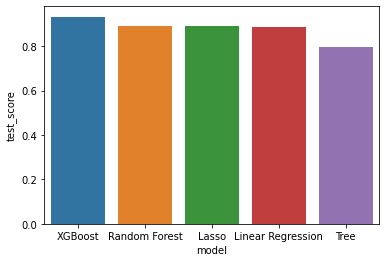

In [68]:
# The bar chart below shows the test scores (R-Squared) for the various models used in descending order
sns.barplot(data = SCORES, x="model", y="test_score");

In [120]:
#Now, lets make predictions using XGBoost Model
y_predict_xgboost = model_xgboost.predict(test)

In [123]:
#Now, lets export our predictions to a CSV
sub = pd.DataFrame()
sub['Id'] = HouseIds
sub['SalePrice'] = y_predict_xgboost
sub.to_csv('submission.csv', index = False)